In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os

def preprocess_image(image_path, img_size=(640, 640)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")

    # Replace all white pixels (value > 250) with black
    image[image > 250] = 0

    original_shape = image.shape

    # Detect and remove white borders using Otsu's thresholding
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find all non-white pixels and get their coordinates
    non_white_pixels = np.where(thresh < 255)

    if non_white_pixels[0].size == 0 or non_white_pixels[1].size == 0:
        raise ValueError("No relevant pixels found in the image.")

    # Get the smallest and largest x and y coordinates and use them to create the bounding box
    y_min, y_max = np.min(non_white_pixels[0]), np.max(non_white_pixels[0])
    x_min, x_max = np.min(non_white_pixels[1]), np.max(non_white_pixels[1])

    # Crop the image to the bounding box of all non-white pixels
    image = image[y_min:y_max+1, x_min:x_max+1]

    # Noise reduction using median blur, bilateral filter, and non-local means denoising
    image_median = cv2.medianBlur(image, 5)
    image_bilateral = cv2.bilateralFilter(image_median, 9, 75, 75)
    image_denoised = cv2.fastNlMeansDenoising(image_bilateral, h=30)

    # Wavelet denoising
    coeffs = pywt.wavedec2(image_denoised, 'db1', level=2)
    coeffs[1:] = [tuple(pywt.threshold(i, value=10, mode='soft') for i in level) for level in coeffs[1:]]
    image_wavelet_denoised = pywt.waverec2(coeffs, 'db1')

    # Resize the denoised image
    image_resized = cv2.resize(image_wavelet_denoised, img_size)
    image_resized = np.expand_dims(image_resized, axis=-1)
    image_resized = np.expand_dims(image_resized, axis=0)
    image_resized = image_resized.astype('float32') / 255.0

    return image, image_resized, original_shape, (y_min, y_max, x_min, x_max)

def binary_mask(image):
    # Convert the processed image to uint8
    image_uint8 = (image * 255).astype(np.uint8).squeeze()

    # Apply Otsu's binary thresholding
    _, binary_image = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def canny_edge_detection(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

def extract_highest_y(edges):
    height, width = edges.shape
    highest_y_values = np.full(width, height)  # Initialize with maximum Y values (bottom of image)

    for x in range(width):
        column = edges[:, x]
        y_indices = np.where(column > 0)[0]
        if y_indices.size > 0:
            # Sort y_indices to find the highest (smallest) y value that's not 0
            y_indices = np.sort(y_indices)
            for y in y_indices:
                if y != 0:
                    highest_y_values[x] = y
                    break
            else:
                # If all y values are 0, set to the smallest y value (0)
                highest_y_values[x] = y_indices[0]
        else:
            # Handle the case when no edges are found in the column
            if x > 0:
                highest_y_values[x] = highest_y_values[x - 1]
            else:
                highest_y_values[x] = height

    return highest_y_values

def plot_highest_y_on_edges(edges, highest_y_values):
    height, width = edges.shape
    output_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure we don't plot outside the image
            cv2.line(output_image, (x, height), (x, y), (0, 255, 0), 1)  # Plot lines in green

    return output_image

def plot_only_highest_y_values(edges, highest_y_values):
    height, width = edges.shape
    output_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert edges to a color image

    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure the Y value is within image bounds
            cv2.circle(output_image, (x, y), 1, (0, 255, 0), -1)  # Draw a small green dot at the highest Y value

    return output_image

def plot_highest_y_on_original(original_image, highest_y_values, scale):
    height, width = original_image.shape
    output_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)  # Convert to color image for drawing

    for x, y in enumerate(highest_y_values):
        scaled_x = int(x * scale[1])
        scaled_y = int(y * scale[0])
        if scaled_y < height and scaled_y >= 0 and scaled_x < width and scaled_x >= 0:
            cv2.circle(output_image, (scaled_x, scaled_y), 2, (0, 255, 0), -1)  # Draw a small green dot at the highest Y value

    return output_image

def detect_vertical_gaps(highest_y_values, gap_threshold=5):
    gaps = []
    start_end_points = []
    for x in range(1, len(highest_y_values)):
        if abs(highest_y_values[x] - highest_y_values[x - 1]) > gap_threshold:
            start_end_points.append((x - 1, x))
            gaps.append((x, (highest_y_values[x] + highest_y_values[x - 1]) // 2))
    return gaps, start_end_points

def plot_gaps(output_image, gaps):
    for x, y in gaps:
        cv2.circle(output_image, (x, y), 5, (255, 0, 0), 2)  # Draw a red circle around each gap

    return output_image

def calculate_tangent_vectors(highest_y_values, start_end_points):
    tangent_vectors = []
    for start, end in start_end_points:
        start_point = (start, highest_y_values[start])
        end_point = (end, highest_y_values[end])
        vector = (end_point[0] - start_point[0], end_point[1] - start_point[1])
        tangent_vectors.append((start_point, vector))
    return tangent_vectors

def remove_border_vectors(tangent_vectors, image_width, border_margin=30):
    # Remove rising vectors close to the left border
    tangent_vectors = [vec for vec in tangent_vectors if not (vec[0][0] < border_margin and vec[1][1] < 0)]

    # Remove falling vectors close to the right border
    tangent_vectors = [vec for vec in tangent_vectors if not (vec[0][0] > image_width - border_margin and vec[1][1] > 0)]

    return tangent_vectors

def plot_tangent_vectors(image, tangent_vectors):
    for (start_x, start_y), (vec_x, vec_y) in tangent_vectors:
        end_x = start_x + vec_x
        end_y = start_y + vec_y
        cv2.arrowedLine(image, (start_x, start_y), (end_x, end_y), (255, 0, 255), 2, tipLength=0.2)
    return image

def detect_single_rising_falling_patterns(tangent_vectors):
    patterns = []
    i = 0
    while i < len(tangent_vectors) - 1:
        if tangent_vectors[i][1][1] < 0 and tangent_vectors[i + 1][1][1] > 0:
            patterns.append((tangent_vectors[i], tangent_vectors[i + 1]))
            i += 2  # Move past this pattern
        else:
            i += 1
    return patterns

def draw_pattern_circles(image, patterns, scale=(1.0, 1.0)):
    for rising_vector, falling_vector in patterns:
        x_coords = [rising_vector[0][0], falling_vector[0][0]]
        y_coords = [rising_vector[0][1], falling_vector[0][1]]

        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)

        center_x = int((min_x + max_x) // 2 * scale[1])
        center_y = int((min_y + max_y) // 2 * scale[0])
        radius = int(np.sqrt((max_x - min_x) ** 2 + (max_y - min_y) ** 2) / 2 * max(scale))

        cv2.circle(image, (center_x, center_y), radius, (255, 0, 0), 2)
    return image

def concatenate_paths(base_path, filenames):
    return [os.path.join(base_path, filename) for filename in filenames]

def process_and_visualize_images(image_paths):
    for image_path in image_paths:
        # Preprocess the image
        original_image, preprocessed_image, original_shape, crop_coords = preprocess_image(image_path)

        # Apply binary masking
        binary_image = binary_mask(preprocessed_image)

        # Apply Canny edge detection
        edges = canny_edge_detection(binary_image)

        # Extract highest Y value edges
        highest_y_values = extract_highest_y(edges)

        # Plot highest Y values on the edges image
        edges_with_highest_y = plot_highest_y_on_edges(edges, highest_y_values)

        # Plot only highest Y values
        highest_y_only = plot_only_highest_y_values(edges, highest_y_values)

        # Plot only highest Y values with dots
        highest_y_with_dots = plot_only_highest_y_values(edges, highest_y_values)

        # Detect vertical gaps and get start-end points
        gaps, start_end_points = detect_vertical_gaps(highest_y_values)

        # Plot gaps on the highest Y values image
        highest_y_with_gaps = plot_gaps(highest_y_only.copy(), gaps)

        # Calculate tangent vectors
        tangent_vectors = calculate_tangent_vectors(highest_y_values, start_end_points)
        print(f"Tangent vectors for {image_path}: {tangent_vectors}")

        # Remove border vectors
        image_width = edges.shape[1]
        tangent_vectors = remove_border_vectors(tangent_vectors, image_width)
        print(f"Tangent vectors after border removal for {image_path}: {tangent_vectors}")

        # Detect single rising and falling patterns
        single_patterns = detect_single_rising_falling_patterns(tangent_vectors)

        print(f"Single rising and falling patterns for {image_path}: {single_patterns}")

        # Draw circles around the detected patterns
        image_with_pattern_circles = draw_pattern_circles(highest_y_only.copy(), single_patterns)

        # Draw circles around the detected patterns on the original image
        scale = (original_shape[0] / 640, original_shape[1] / 640)
        original_with_pattern_circles = draw_pattern_circles(original_image.copy(), single_patterns, scale)

        # Plot highest Y values with dots on the original image
        original_with_dots = plot_highest_y_on_original(original_image.copy(), highest_y_values, scale)

        # Plot tangent vectors on a separate image without circles
        highest_y_with_vectors = plot_tangent_vectors(highest_y_only.copy(), tangent_vectors)

        # Visualize the results
        plt.figure(figsize=(40, 5))
        # plt.subplot(1, 10, 1)
        # plt.imshow(original_image, cmap='gray')
        # plt.title('Original Image')

        # plt.subplot(1, 10, 2)
        # plt.imshow(binary_image, cmap='gray')
        # plt.title('Binary Mask')

        # plt.subplot(1, 10, 3)
        # plt.imshow(edges, cmap='gray')
        # plt.title('Canny Edges')

        # plt.subplot(1, 10, 4)
        # plt.imshow(edges_with_highest_y)
        # plt.title('Highest Y Values on Edges')

        # plt.subplot(1, 10, 5)
        # plt.imshow(highest_y_with_dots)
        # plt.title('Highest Y Values with Dots')

        # plt.subplot(1, 10, 6)
        # plt.imshow(highest_y_with_gaps)
        # plt.title('Only Highest Y Values with Gaps')

        # plt.subplot(1, 10, 7)
        # plt.imshow(highest_y_with_vectors)
        # plt.title('Only Tangent Vectors')

        # plt.subplot(1, 10, 8)
        # plt.imshow(image_with_pattern_circles)
        # plt.title('Rising-Falling Patterns')

        plt.subplot(1, 10, 9)
        plt.imshow(original_with_pattern_circles, cmap='gray')
        plt.title('Original with Patterns')

        plt.subplot(1, 10, 10)
        plt.imshow(original_with_dots, cmap='gray')
        plt.title('Original with Dots')

        plt.show()

# Example usage

test_filenames = [
    'dr_test_1190_NV.jpg', 'img_02.jpeg', 'img_04.jpeg',
    'img_05.jpeg', 'img_06.jpeg', 'img_07.jpeg',
    'img_08.jpeg', 'img_09.jpeg', 'img_10.jpeg',
    'img_11.jpeg', 'img_15.jpeg', 'img_16.jpeg',
    'img_17.jpeg', 'img_18.jpeg', 'img_19.jpeg',
    'img_21.jpeg', 'img_23.jpeg', 'img_24.jpeg',
    'img_25.jpeg'
]
gt_filenames = [
    'dr_test_1190_NV.jpg', 'img_02.jpeg', 'img_04.jpeg',
    'img_05.jpeg', 'img_06.jpeg', 'img_07.jpeg',
    'img_08.jpeg', 'img_09.jpeg', 'img_10.jpeg',
    'img_11.jpeg', 'img_15.jpeg', 'img_16.jpeg',
    'img_17.jpeg', 'img_18.jpeg', 'img_19.jpeg',
    'img_21.jpeg', 'img_23.jpeg', 'img_24.jpeg',
    'img_25.jpeg'
]

test_base_path = 'DATA_OCT'

gt_base_path = 'NV_GT'

test_image_paths = concatenate_paths(test_base_path, test_filenames)
gt_image_paths = concatenate_paths(gt_base_path, gt_filenames)

process_and_visualize_images(test_image_paths)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os

def preprocess_image(image_path, img_size=(640, 640)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")

    # Replace all white pixels (value > 250) with black
    image[image > 250] = 0

    original_shape = image.shape

    # Detect and remove white borders using Otsu's thresholding
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find all non-white pixels and get their coordinates
    non_white_pixels = np.where(thresh < 255)

    if non_white_pixels[0].size == 0 or non_white_pixels[1].size == 0:
        raise ValueError("No relevant pixels found in the image.")

    # Get the smallest and largest x and y coordinates and use them to create the bounding box
    y_min, y_max = np.min(non_white_pixels[0]), np.max(non_white_pixels[0])
    x_min, x_max = np.min(non_white_pixels[1]), np.max(non_white_pixels[1])

    # Crop the image to the bounding box of all non-white pixels
    image = image[y_min:y_max+1, x_min:x_max+1]

    # Noise reduction using median blur, bilateral filter, and non-local means denoising
    image_median = cv2.medianBlur(image, 5)
    image_bilateral = cv2.bilateralFilter(image_median, 9, 75, 75)
    image_denoised = cv2.fastNlMeansDenoising(image_bilateral, h=30)

    # Wavelet denoising
    coeffs = pywt.wavedec2(image_denoised, 'db1', level=2)
    coeffs[1:] = [tuple(pywt.threshold(i, value=10, mode='soft') for i in level) for level in coeffs[1:]]
    image_wavelet_denoised = pywt.waverec2(coeffs, 'db1')

    # Resize the denoised image
    image_resized = cv2.resize(image_wavelet_denoised, img_size)
    image_resized = np.expand_dims(image_resized, axis=-1)
    image_resized = np.expand_dims(image_resized, axis=0)
    image_resized = image_resized.astype('float32') / 255.0

    return image, image_resized, original_shape, (y_min, y_max, x_min, x_max)

def binary_mask(image):
    # Convert the processed image to uint8
    image_uint8 = (image * 255).astype(np.uint8).squeeze()

    # Apply Otsu's binary thresholding
    _, binary_image = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def canny_edge_detection(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

def extract_highest_y(edges):
    height, width = edges.shape
    highest_y_values = np.full(width, height)  # Initialize with maximum Y values (bottom of image)

    for x in range(width):
        column = edges[:, x]
        y_indices = np.where(column > 0)[0]
        if y_indices.size > 0:
            # Sort y_indices to find the highest (smallest) y value that's not 0
            y_indices = np.sort(y_indices)
            for y in y_indices:
                if y != 0:
                    highest_y_values[x] = y
                    break
            else:
                # If all y values are 0, set to the smallest y value (0)
                highest_y_values[x] = y_indices[0]
        else:
            # Handle the case when no edges are found in the column
            if x > 0:
                highest_y_values[x] = highest_y_values[x - 1]
            else:
                highest_y_values[x] = height

    return highest_y_values

def plot_highest_y_on_edges(edges, highest_y_values):
    height, width = edges.shape
    output_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure we don't plot outside the image
            cv2.line(output_image, (x, height), (x, y), (0, 255, 0), 1)  # Plot lines in green

    return output_image

def plot_only_highest_y_values(edges, highest_y_values):
    height, width = edges.shape
    output_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert edges to a color image

    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure the Y value is within image bounds
            cv2.circle(output_image, (x, y), 1, (0, 255, 0), -1)  # Draw a small green dot at the highest Y value

    return output_image

def plot_highest_y_on_original(original_image, highest_y_values, scale):
    height, width = original_image.shape
    output_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)  # Convert to color image for drawing

    for x, y in enumerate(highest_y_values):
        scaled_x = int(x * scale[1])
        scaled_y = int(y * scale[0])
        if scaled_y < height and scaled_y >= 0 and scaled_x < width and scaled_x >= 0:
            cv2.circle(output_image, (scaled_x, scaled_y), 2, (0, 255, 0), -1)  # Draw a small green dot at the highest Y value

    return output_image

def detect_vertical_gaps(highest_y_values, gap_threshold=5):
    gaps = []
    start_end_points = []
    for x in range(1, len(highest_y_values)):
        if abs(highest_y_values[x] - highest_y_values[x - 1]) > gap_threshold:
            start_end_points.append((x - 1, x))
            gaps.append((x, (highest_y_values[x] + highest_y_values[x - 1]) // 2))
    return gaps, start_end_points

def plot_gaps(output_image, gaps):
    for x, y in gaps:
        cv2.circle(output_image, (x, y), 5, (255, 0, 0), 2)  # Draw a red circle around each gap

    return output_image

def calculate_tangent_vectors(highest_y_values, start_end_points):
    tangent_vectors = []
    for start, end in start_end_points:
        start_point = (start, highest_y_values[start])
        end_point = (end, highest_y_values[end])
        vector = (end_point[0] - start_point[0], end_point[1] - start_point[1])
        tangent_vectors.append((start_point, vector))
    return tangent_vectors

def remove_border_vectors(tangent_vectors, image_width, border_margin=30):
    # Remove rising vectors close to the left border
    tangent_vectors = [vec for vec in tangent_vectors if not (vec[0][0] < border_margin and vec[1][1] < 0)]

    # Remove falling vectors close to the right border
    tangent_vectors = [vec for vec in tangent_vectors if not (vec[0][0] > image_width - border_margin and vec[1][1] > 0)]

    return tangent_vectors

def plot_tangent_vectors(image, tangent_vectors):
    for (start_x, start_y), (vec_x, vec_y) in tangent_vectors:
        end_x = start_x + vec_x
        end_y = start_y + vec_y
        cv2.arrowedLine(image, (start_x, start_y), (end_x, end_y), (255, 0, 255), 2, tipLength=0.2)
    return image

def detect_single_rising_falling_patterns(tangent_vectors):
    patterns = []
    i = 0
    while i < len(tangent_vectors) - 1:
        if tangent_vectors[i][1][1] < 0 and tangent_vectors[i + 1][1][1] > 0:
            patterns.append((tangent_vectors[i], tangent_vectors[i + 1]))
            i += 2  # Move past this pattern
        else:
            i += 1
    return patterns

def draw_pattern_circles(image, patterns, scale=(1.0, 1.0)):
    for rising_vector, falling_vector in patterns:
        x_coords = [rising_vector[0][0], falling_vector[0][0]]
        y_coords = [rising_vector[0][1], falling_vector[0][1]]

        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)

        center_x = int((min_x + max_x) // 2 * scale[1])
        center_y = int((min_y + max_y) // 2 * scale[0])
        radius = int(np.sqrt((max_x - min_x) ** 2 + (max_y - min_y) ** 2) / 2 * max(scale))

        cv2.circle(image, (center_x, center_y), radius, (255, 0, 0), 2)
    return image


def concatenate_paths(base_path, filenames):
    return [os.path.join(base_path, filename) for filename in filenames]

def read_ground_truth_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Mask at path {mask_path} not found.")
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return binary_mask

def is_within_ground_truth(x, y, ground_truth_mask):
    return ground_truth_mask[y, x] == 255

def compare_patterns_with_ground_truth_mask(detected_patterns, ground_truth_mask):
    correct_count = 0

    for (rising_vector, falling_vector) in detected_patterns:
        detected_x = (rising_vector[0][0] + falling_vector[0][0]) // 2
        detected_y = (rising_vector[0][1] + falling_vector[0][1]) // 2

        if is_within_ground_truth(detected_x, detected_y, ground_truth_mask):
            correct_count += 1

    return correct_count

def process_and_visualize_images(test_image_paths, gt_image_paths):
    for test_image_path, gt_image_path in zip(test_image_paths, gt_image_paths):
        print(f"Processing {test_image_path} with ground truth {gt_image_path}")

        # Preprocess the image
        original_image, preprocessed_image, original_shape, crop_coords = preprocess_image(test_image_path)
        
        # Convert the processed image to uint8 for further processing
        processed_image_uint8 = (preprocessed_image * 255).astype(np.uint8).squeeze()

        # Apply binary masking
        binary_image = binary_mask(preprocessed_image)

        # Apply Canny edge detection
        edges = canny_edge_detection(binary_image)

        # Extract highest Y value edges
        highest_y_values = extract_highest_y(edges)

        # Plot highest Y values on the original image
        original_with_highest_y = plot_highest_y_on_original(original_image.copy(), highest_y_values, scale=(1, 1))

        # Detect vertical gaps and get start-end points
        gaps, start_end_points = detect_vertical_gaps(highest_y_values)

        # Calculate tangent vectors
        tangent_vectors = calculate_tangent_vectors(highest_y_values, start_end_points)

        # Remove border vectors
        image_width = edges.shape[1]
        tangent_vectors = remove_border_vectors(tangent_vectors, image_width)

        # Detect single rising and falling patterns
        single_patterns = detect_single_rising_falling_patterns(tangent_vectors)
        print(f"Detected patterns: {single_patterns}")

        # Draw circles around the detected patterns on the original image
        original_with_patterns = draw_pattern_circles(original_with_highest_y.copy(), single_patterns, scale=(1, 1))


        # Read ground truth mask and resize to match processed image size
        ground_truth_mask = read_ground_truth_mask(gt_image_path)
        ground_truth_mask_resized = cv2.resize(ground_truth_mask, (processed_image_uint8.shape[1], processed_image_uint8.shape[0]))


        # Compare detected patterns with resized ground truth mask
        correct_count = compare_patterns_with_ground_truth_mask(single_patterns, ground_truth_mask_resized)
        print(f"Number of correctly detected patterns: {correct_count}")

        # Display images for visual inspection
        plt.figure(figsize=(15, 15))

        plt.subplot(2, 3, 1)
        plt.title("Original Image")
        plt.imshow(original_image, cmap='gray')

        plt.subplot(2, 3, 2)
        plt.title("Processed Image")
        plt.imshow(processed_image_uint8, cmap='gray')

        plt.subplot(2, 3, 3)
        plt.title("Edges with Highest Y Values")
        plt.imshow(plot_highest_y_on_edges(edges.copy(), highest_y_values), cmap='gray')

        plt.subplot(2, 3, 4)
        plt.title("Original with Detected Patterns")
        plt.imshow(original_with_patterns, cmap='gray')

        plt.subplot(2, 3, 5)
        plt.title("Ground Truth Mask")
        plt.imshow(ground_truth_mask_resized, cmap='gray')

        plt.show()
        
# Example usage:
test_filenames = [
    'dr_test_1190_NV.jpg', 'img_02.jpeg', 'img_04.jpeg',
    'img_05.jpeg', 'img_06.jpeg', 'img_07.jpeg',
    'img_08.jpeg', 'img_09.jpeg', 'img_10.jpeg',
    'img_11.jpeg', 'img_15.jpeg', 'img_16.jpeg',
    'img_17.jpeg', 'img_18.jpeg', 'img_19.jpeg',
    'img_21.jpeg', 'img_23.jpeg', 'img_24.jpeg',
    'img_25.jpeg'
]
gt_filenames = [
    'dr_test_1190_NV (1)_NV.png', 'img_02 (1)_NV.png', 'img_04_NV.png',
'img_05_NV.png', 'img_06_NV.png', 'img_07_NV.png',
'img_08_NV.png', 'img_09 (1)_NV.png', 'img_10_NV.png',
'img_11 (1)_NV.png', 'img_15_NV.png', 'img_16_NV.png',
'img_17_NV.png', 'img_18_NV.png', 'img_19_NV.png',
'img_21 (1)_NV.png', 'img_23_NV.png', 'img_24_NV.png',
    'img_25_NV.png'
]

test_base_path = 'DATA_OCT'
gt_base_path = 'NV_GT'

test_image_paths = concatenate_paths(test_base_path, test_filenames)
gt_image_paths = concatenate_paths(gt_base_path, gt_filenames)

process_and_visualize_images(test_image_paths, gt_image_paths)


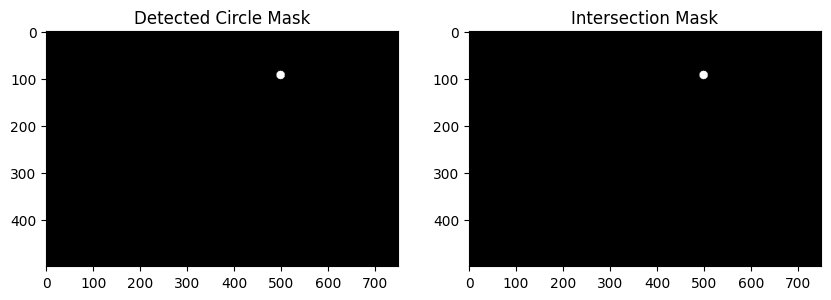

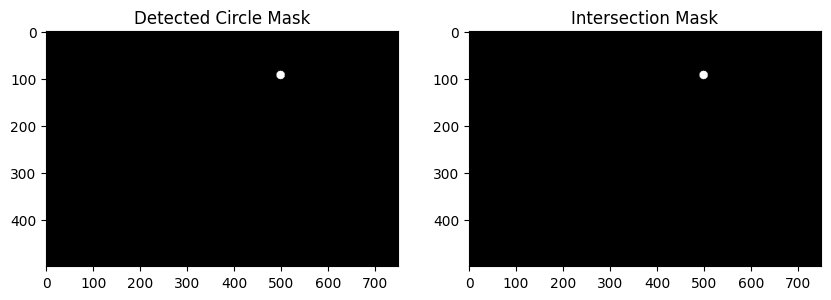

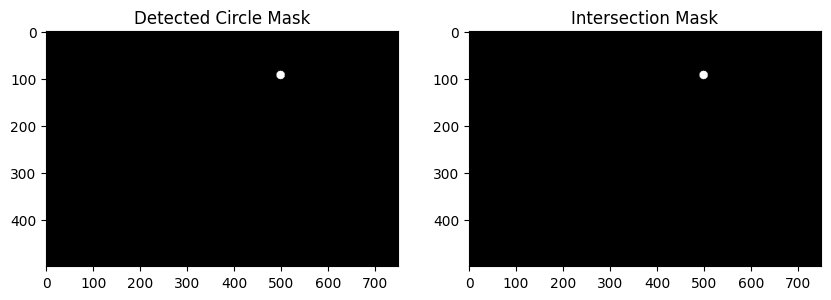

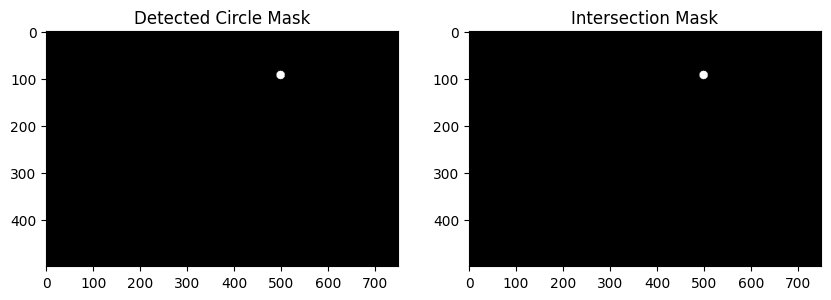

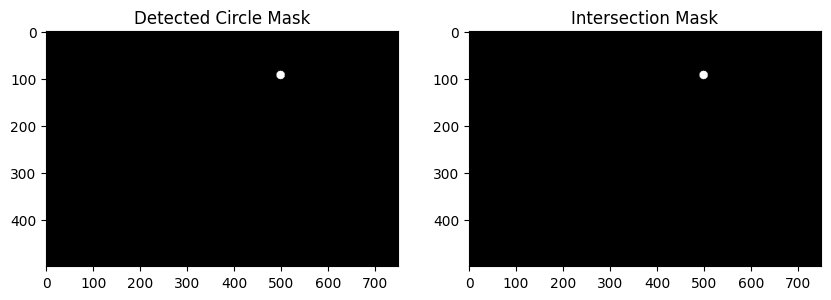

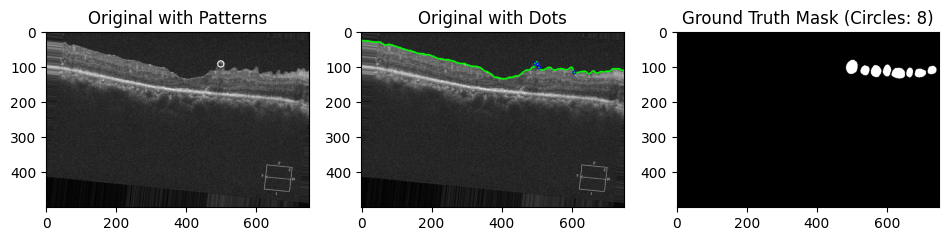

Correct patterns detected: 1 / 8


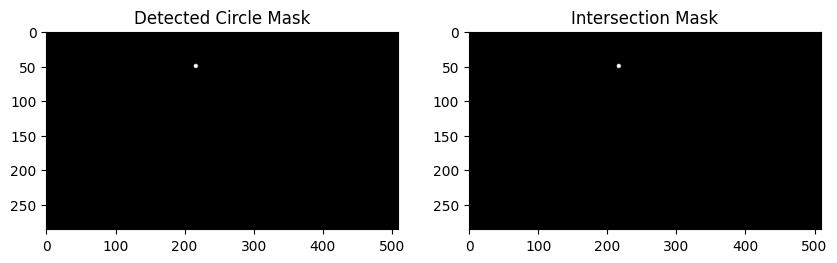

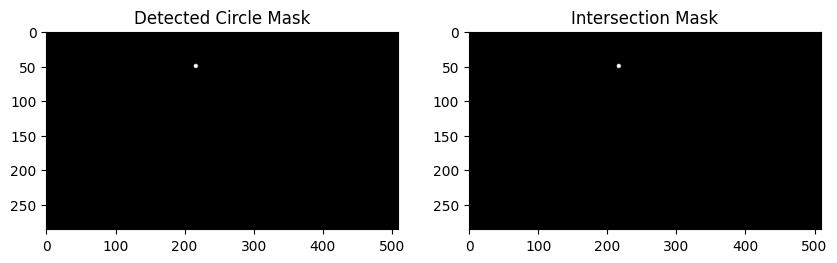

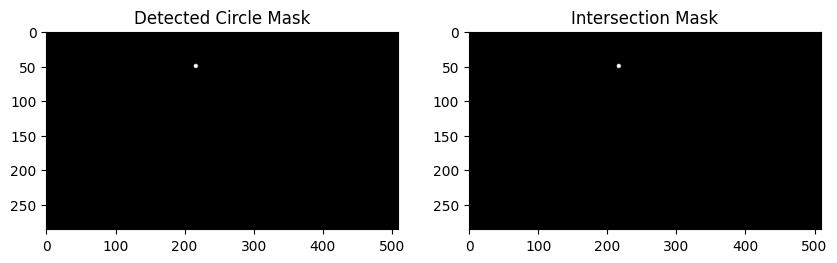

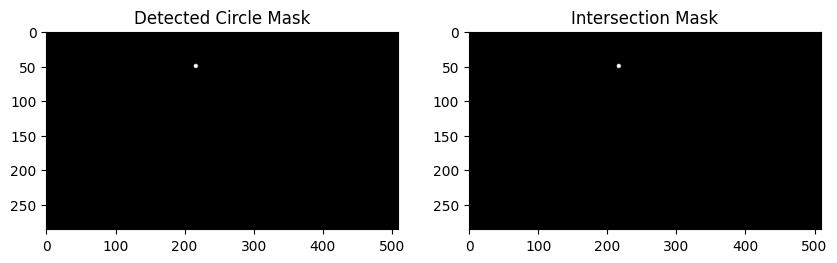

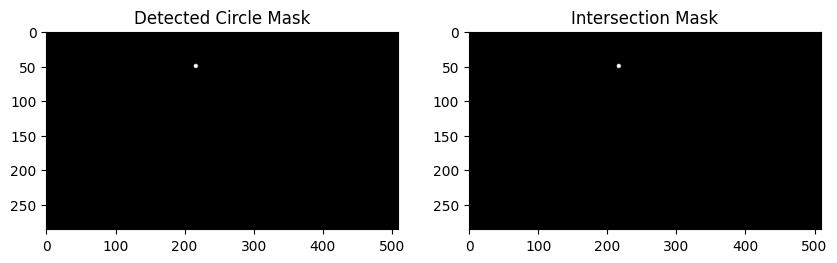

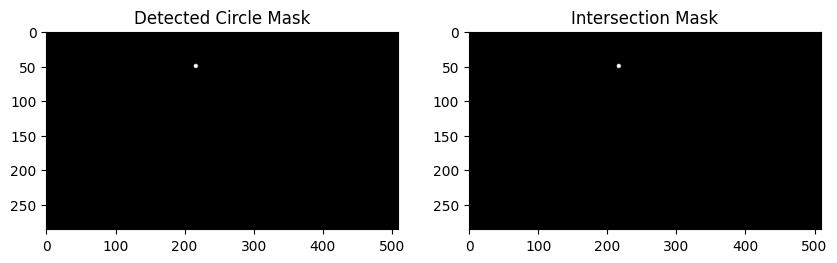

KeyboardInterrupt: 

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os

def preprocess_image(image_path, img_size=(640, 640)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")

    # Replace all white pixels (value > 250) with black
    image[image > 250] = 0

    original_shape = image.shape

    # Detect and remove white borders using Otsu's thresholding
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find all non-white pixels and get their coordinates
    non_white_pixels = np.where(thresh < 255)

    if non_white_pixels[0].size == 0 or non_white_pixels[1].size == 0:
        raise ValueError("No relevant pixels found in the image.")

    # Get the smallest and largest x and y coordinates and use them to create the bounding box
    y_min, y_max = np.min(non_white_pixels[0]), np.max(non_white_pixels[0])
    x_min, x_max = np.min(non_white_pixels[1]), np.max(non_white_pixels[1])

    # Crop the image to the bounding box of all non-white pixels
    image = image[y_min:y_max+1, x_min:x_max+1]

    # Noise reduction using median blur, bilateral filter, and non-local means denoising
    image_median = cv2.medianBlur(image, 5)
    image_bilateral = cv2.bilateralFilter(image_median, 9, 75, 75)
    image_denoised = cv2.fastNlMeansDenoising(image_bilateral, h=30)

    # Wavelet denoising
    coeffs = pywt.wavedec2(image_denoised, 'db1', level=2)
    coeffs[1:] = [tuple(pywt.threshold(i, value=10, mode='soft') for i in level) for level in coeffs[1:]]
    image_wavelet_denoised = pywt.waverec2(coeffs, 'db1')

    # Resize the denoised image
    image_resized = cv2.resize(image_wavelet_denoised, img_size)
    image_resized = np.expand_dims(image_resized, axis=-1)
    image_resized = np.expand_dims(image_resized, axis=0)
    image_resized = image_resized.astype('float32') / 255.0

    return image, image_resized, original_shape, (y_min, y_max, x_min, x_max)

def binary_mask(image):
    # Convert the processed image to uint8
    image_uint8 = (image * 255).astype(np.uint8).squeeze()

    # Apply Otsu's binary thresholding
    _, binary_image = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def canny_edge_detection(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

def extract_highest_y(edges):
    height, width = edges.shape
    highest_y_values = np.full(width, height)  # Initialize with maximum Y values (bottom of image)

    for x in range(width):
        column = edges[:, x]
        y_indices = np.where(column > 0)[0]
        if y_indices.size > 0:
            # Sort y_indices to find the highest (smallest) y value that's not 0
            y_indices = np.sort(y_indices)
            for y in y_indices:
                if y != 0:
                    highest_y_values[x] = y
                    break
            else:
                # If all y values are 0, set to the smallest y value (0)
                highest_y_values[x] = y_indices[0]
        else:
            # Handle the case when no edges are found in the column
            if x > 0:
                highest_y_values[x] = highest_y_values[x - 1]
            else:
                highest_y_values[x] = height

    return highest_y_values

def plot_highest_y_on_edges(edges, highest_y_values):
    height, width = edges.shape
    output_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure we don't plot outside the image
            cv2.line(output_image, (x, height), (x, y), (0, 255, 0), 1)  # Plot lines in green

    return output_image

def plot_only_highest_y_values(edges, highest_y_values):
    height, width = edges.shape
    output_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert edges to a color image

    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure the Y value is within image bounds
            cv2.circle(output_image, (x, y), 1, (0, 255, 0), -1)  # Draw a small green dot at the highest Y value

    return output_image

def plot_highest_y_on_original(original_image, highest_y_values, scale):
    height, width = original_image.shape
    output_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)  # Convert to color image for drawing

    for x, y in enumerate(highest_y_values):
        scaled_x = int(x * scale[1])
        scaled_y = int(y * scale[0])
        if scaled_y < height and scaled_y >= 0 and scaled_x < width and scaled_x >= 0:
            cv2.circle(output_image, (scaled_x, scaled_y), 2, (0, 255, 0), -1)  # Draw a small green dot at the highest Y value

    return output_image

def detect_vertical_gaps(highest_y_values, gap_threshold=5):
    gaps = []
    start_end_points = []
    for x in range(1, len(highest_y_values)):
        if abs(highest_y_values[x] - highest_y_values[x - 1]) > gap_threshold:
            start_end_points.append((x - 1, x))
            gaps.append((x, (highest_y_values[x] + highest_y_values[x - 1]) // 2))
    return gaps, start_end_points

def plot_gaps(output_image, gaps):
    for x, y in gaps:
        cv2.circle(output_image, (x, y), 5, (255, 0, 0), 2)  # Draw a red circle around each gap

    return output_image

def calculate_tangent_vectors(highest_y_values, start_end_points):
    tangent_vectors = []
    for start, end in start_end_points:
        start_point = (start, highest_y_values[start])
        end_point = (end, highest_y_values[end])
        vector = (end_point[0] - start_point[0], end_point[1] - start_point[1])
        tangent_vectors.append((start_point, vector))
    return tangent_vectors

def remove_border_vectors(tangent_vectors, image_width, border_margin=30):
    # Remove rising vectors close to the left border
    tangent_vectors = [vec for vec in tangent_vectors if not (vec[0][0] < border_margin and vec[1][1] < 0)]

    # Remove falling vectors close to the right border
    tangent_vectors = [vec for vec in tangent_vectors if not (vec[0][0] > image_width - border_margin and vec[1][1] > 0)]

    return tangent_vectors

def plot_tangent_vectors(image, tangent_vectors):
    for (start_x, start_y), (vec_x, vec_y) in tangent_vectors:
        end_x = start_x + vec_x
        end_y = start_y + vec_y
        cv2.arrowedLine(image, (start_x, start_y), (end_x, end_y), (255, 0, 255), 2, tipLength=0.2)
    return image

def detect_single_rising_falling_patterns(tangent_vectors):
    patterns = []
    i = 0
    while i < len(tangent_vectors) - 1:
        if tangent_vectors[i][1][1] < 0 and tangent_vectors[i + 1][1][1] > 0:
            patterns.append((tangent_vectors[i], tangent_vectors[i + 1]))
            i += 2  # Move past this pattern
        else:
            i += 1
    return patterns

def draw_pattern_circles(image, patterns, scale=(1.0, 1.0)):
    for rising_vector, falling_vector in patterns:
        x_coords = [rising_vector[0][0], falling_vector[0][0]]
        y_coords = [rising_vector[0][1], falling_vector[0][1]]

        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)

        center_x = int((min_x + max_x) // 2 * scale[1])
        center_y = int((min_y + max_y) // 2 * scale[0])
        radius = int(np.sqrt((max_x - min_x) ** 2 + (max_y - min_y) ** 2) / 2 * max(scale))

        cv2.circle(image, (center_x, center_y), radius, (255, 0, 0), 2)
    return image

def concatenate_paths(base_path, filenames):
    return [os.path.join(base_path, filename) for filename in filenames]


def detect_unusual_spots(highest_y_values, deviation_threshold=5):
    unusual_spots = []
    for x in range(1, len(highest_y_values)):
        deviation = abs(highest_y_values[x] - highest_y_values[x - 1])
        if deviation > deviation_threshold:
            unusual_spots.append((x, highest_y_values[x]))
    return unusual_spots


def plot_highest_y_on_original(original_image, highest_y_values, scale, unusual_spots):
    height, width = original_image.shape
    output_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)  # Convert to color image for drawing

    for x, y in enumerate(highest_y_values):
        scaled_x = int(x * scale[1])
        scaled_y = int(y * scale[0])
        if scaled_y < height and scaled_y >= 0 and scaled_x < width and scaled_x >= 0:
            cv2.circle(output_image, (scaled_x, scaled_y), 2, (0, 255, 0), -1)  # Draw a small green dot at the highest Y value

    for x, y in unusual_spots:
        scaled_x = int(x * scale[1])
        scaled_y = int(y * scale[0])
        if scaled_y < height and scaled_y >= 0 and scaled_x < width and scaled_x >= 0:
            cv2.circle(output_image, (scaled_x, scaled_y), 4, (0, 0, 255), 2)  # Draw a red circle around unusual spots

    return output_image


def read_ground_truth_mask(filepath):
    """
    Reads the ground truth mask image from the given filepath and converts it to a binary mask.
    """
    mask = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return binary_mask

def is_within_or_intersecting_ground_truth(rising_vector, falling_vector, ground_truth_mask, scale):
    """
    Check if a circle with given center (x, y) and radius intersects or is within the ground truth mask.
    """
    x_coords = [rising_vector[0][0], falling_vector[0][0]]
    y_coords = [rising_vector[0][1], falling_vector[0][1]]

    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)

    center_x = int((min_x + max_x) // 2 * scale[1])
    center_y = int((min_y + max_y) // 2 * scale[0])
    radius = int(np.sqrt((max_x - min_x) ** 2 + (max_y - min_y) ** 2) / 2 * max(scale))

    # Create a mask for the detected circle
    circle_mask = np.zeros_like(ground_truth_mask, dtype=np.uint8)
    cv2.circle(circle_mask, (center_x, center_y), radius, 255, -1)  # Draw the detected circle

    # Intersection mask: AND operation between the ground truth mask and the detected circle mask
    intersection_mask = cv2.bitwise_and(ground_truth_mask, circle_mask)

    # Check if there is any overlap (non-zero pixels) in the intersection mask

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(circle_mask, cmap='gray')
    plt.title('Detected Circle Mask')
    plt.subplot(1, 2, 2)
    plt.imshow(intersection_mask, cmap='gray')
    plt.title('Intersection Mask')
    plt.show()

    return np.any(intersection_mask)

def compare_patterns_with_ground_truth_mask(detected_patterns, ground_truth_mask, unusual_spots):
    """
    Compare detected patterns with the ground truth mask to count correct detections.
    """
    correct_count = 0
    scale = (ground_truth_mask.shape[0] / 640, ground_truth_mask.shape[1] / 640)

    for rising_vector, falling_vector in detected_patterns:
        if is_within_or_intersecting_ground_truth(rising_vector, falling_vector, ground_truth_mask, scale):
            correct_count += 1

    for x, y in unusual_spots:
        # Check if the unusual spot is within any of the circles defined by detected patterns
        spot_within_circle = False
        for rising_vector, falling_vector in detected_patterns:
            if is_within_or_intersecting_ground_truth(rising_vector, falling_vector, ground_truth_mask, scale):
                spot_within_circle = True
                break
        
        if not spot_within_circle:
            # If the spot is outside all circles, count it as correct
            correct_count += 1

            # Visualize the unusual spot (optional)
            center_x = int(x * scale[1])
            center_y = int(y * scale[0])
            radius = 4  # Adjust the radius for visualization

            # Create a mask for the unusual spot (circle)
            circle_mask = np.zeros_like(ground_truth_mask, dtype=np.uint8)
            cv2.circle(circle_mask, (center_x, center_y), radius, 255, -1)  # Draw the circle

            # Intersection mask: AND operation between the ground truth mask and the circle mask
            intersection_mask = cv2.bitwise_and(ground_truth_mask, circle_mask)

            # Visualize the circle mask and intersection mask (optional)
           

    return correct_count

def draw_pattern_circles(image, patterns, scale=(1.0, 1.0)):
    for rising_vector, falling_vector in patterns:
        x_coords = [rising_vector[0][0], falling_vector[0][0]]
        y_coords = [rising_vector[0][1], falling_vector[0][1]]

        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)

        center_x = int((min_x + max_x) // 2 * scale[1])
        center_y = int((min_y + max_y) // 2 * scale[0])
        radius = int(np.sqrt((max_x - min_x) ** 2 + (max_y - min_y) ** 2) / 2 * max(scale))

        cv2.circle(image, (center_x, center_y), radius, (255, 0, 0), 2)
    return image




def count_circles_in_ground_truth(ground_truth_mask):
    contours, _ = cv2.findContours(ground_truth_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)

def process_and_visualize_images(test_image_paths, gt_image_paths):
    for test_image_path, gt_image_path in zip(test_image_paths, gt_image_paths):
        # try:
            total_gt_circles = 0
            # Preprocess the image
            original_image, preprocessed_image, original_shape, crop_coords = preprocess_image(test_image_path)

            # Apply binary masking
            binary_image = binary_mask(preprocessed_image)

            # Apply Canny edge detection
            edges = canny_edge_detection(binary_image)

            # Extract highest Y value edges
            highest_y_values = extract_highest_y(edges)

            # Plot highest Y values on the edges image
            edges_with_highest_y = plot_highest_y_on_edges(edges, highest_y_values)

            # Plot only highest Y values with dots
            highest_y_with_dots = plot_only_highest_y_values(edges, highest_y_values)

            # Detect vertical gaps and get start-end points
            gaps, start_end_points = detect_vertical_gaps(highest_y_values)

            # Plot gaps on the highest Y values image
            highest_y_with_gaps = plot_gaps(highest_y_with_dots.copy(), gaps)

            # Calculate tangent vectors
            tangent_vectors = calculate_tangent_vectors(highest_y_values, start_end_points)

            # Remove border vectors
            image_width = edges.shape[1]
            tangent_vectors = remove_border_vectors(tangent_vectors, image_width)

            # Detect single rising and falling patterns
            single_patterns = detect_single_rising_falling_patterns(tangent_vectors)

            # Draw circles around the detected patterns on the original image
            scale = (original_shape[0] / 640, original_shape[1] / 640)
            original_with_pattern_circles = draw_pattern_circles(original_image.copy(), single_patterns, scale)

            # Detect unusual spots
            unusual_spots = detect_unusual_spots(highest_y_values)

            # Plot highest Y values with dots and unusual spots on the original image
            original_with_dots = plot_highest_y_on_original(original_image.copy(), highest_y_values, scale, unusual_spots)

            # Read ground truth mask
            gt_mask = read_ground_truth_mask(gt_image_path)

            # Compare detected patterns with ground truth
            correct_count = compare_patterns_with_ground_truth_mask(single_patterns, gt_mask, unusual_spots)

            # Count circles in ground truth mask
            gt_circle_count = count_circles_in_ground_truth(gt_mask)
            total_gt_circles += gt_circle_count

            # Visualize the results
            plt.figure(figsize=(40, 5))

            plt.subplot(1, 10, 1)
            plt.imshow(original_with_pattern_circles, cmap='gray')
            plt.title('Original with Patterns')

            plt.subplot(1, 10, 2)
            plt.imshow(original_with_dots, cmap='gray')
            plt.title('Original with Dots')

            plt.subplot(1, 10, 3)
            plt.imshow(gt_mask, cmap='gray')
            plt.title(f'Ground Truth Mask (Circles: {gt_circle_count})')


    
            plt.show()

            print(f"Correct patterns detected: {correct_count} / {total_gt_circles}")

        # except Exception as e:
        #     print(f"Error processing {test_image_path}: {str(e)}")

    print(f"Total circles in ground truth masks: {total_gt_circles}")
# Example usage:
test_filenames = [
    'dr_test_1190_NV.jpg', 'img_02.jpeg', 'img_04.jpeg',
    'img_05.jpeg', 'img_06.jpeg', 'img_07.jpeg',
    'img_08.jpeg', 'img_09.jpeg', 'img_10.jpeg',
    'img_11.jpeg', 'img_15.jpeg', 'img_16.jpeg',
    'img_17.jpeg', 'img_18.jpeg', 'img_19.jpeg',
    'img_21.jpeg', 'img_23.jpeg', 'img_24.jpeg',
    'img_25.jpeg'
]
gt_filenames = [
    'dr_test_1190_NV (1)_NV.png', 'img_02 (1)_NV.png', 'img_04_NV.png',
    'img_05_NV.png', 'img_06_NV.png', 'img_07_NV.png',
    'img_08_NV.png', 'img_09 (1)_NV.png', 'img_10_NV.png',
    'img_11 (1)_NV.png', 'img_15_NV.png', 'img_16_NV.png',
    'img_17_NV.png', 'img_18_NV.png', 'img_19_NV.png',
    'img_21 (1)_NV.png', 'img_23_NV.png', 'img_24_NV.png',
    'img_25_NV.png'
]

test_base_path = 'DATA_OCT'
gt_base_path = 'NV_GT'

test_image_paths = concatenate_paths(test_base_path, test_filenames)
gt_image_paths = concatenate_paths(gt_base_path, gt_filenames)

process_and_visualize_images(test_image_paths, gt_image_paths)